In [1]:
from netcal.presentation import ReliabilityDiagram
from netcal.scaling import TemperatureScaling
from netcal.metrics import ECE

from glob import glob
from time import time
import numpy as np
import sys
import os

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch

sys.path.append(os.path.abspath('../'))
from dataset import create_loader
import models
import utils

In [2]:
def ece_score(py, y_test, n_bins=10):
    py = np.array(py)
    y_test = np.array(y_test)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    py_index = np.argmax(py, axis=1)
    py_value = []

    for i in range(py.shape[0]):
        py_value.append(py[i, py_index[i]])
        
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(py.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)


def get_ECE(output_all, ground_truth):

    confidences = np.concatenate(output_all)
    ground_truth = np.array(ground_truth)

    temperature = TemperatureScaling()
    temperature.fit(confidences, ground_truth)
    calibrated = temperature.transform(confidences)

    n_bins = 20

    ece = ECE(n_bins)
    uncalibrated_score = ece.measure(confidences, ground_truth)
    calibrated_score = ece.measure(calibrated, ground_truth)


    diagram = ReliabilityDiagram(n_bins)
    diagram.plot(confidences, ground_truth)  # visualize miscalibration of uncalibrated
    print("ECE : ", calibrated_score)


In [3]:
def TestModel(model_name, dataloader, lrp_gamma=1.0, device = 'cuda'):
    model_dict = {
        "resnet20": models.resnet20,
        "resnet32": models.resnet32,
        "resnet56": models.resnet56,
        "resnet110": models.resnet110
    }

    model = model_dict.get(model_name)(num_classes=100).to(device)
    model.load_state_dict(torch.load(f"./../TEACHER_models/CIFAR100/{model_name}/model.pth"))

    softmax = torch.nn.Softmax(dim=1)
    all_data =  dataloader.dataset.__len__()
    all_label = dataloader.dataset.targets

    output_all_refine = []
    output_all_origin = []
    correct_refine = 0
    correct_origin = 0

    refiner = utils.Refiner(teacher=model, lrp_gamma=lrp_gamma)
    model.eval()

    for img, label in dataloader:
        img = img.to(device)
        label = label.to(device)
        refined_img = refiner.get_refined_image(img, label) # 

        with torch.no_grad():
            output_origin = softmax(model(img))
            output_all_origin.append(output_origin.cpu().detach().numpy())
            correct_origin += torch.sum(torch.argmax(output_origin, dim=1) == label)
        
            output_refine = softmax(model(refined_img))
            correct_refine += torch.sum(torch.argmax(output_refine, dim=1) == label)
            output_all_refine.append(output_refine.cpu().detach().numpy())


    print("==========================GI==========================")
    print("ACC : ", correct_refine / all_data * 100)
    get_ECE(output_all_refine, all_label)

    print("========================ORIGIN========================")
    print("ACC : ", correct_origin / all_data * 100)
    get_ECE(output_all_origin, all_label)


# CIFAR 100

Files already downloaded and verified
Files already downloaded and verified
==========================GI==========================
ACC :  tensor(85.6400, device='cuda:0')
ECE :  0.013793472134321874
========================ORIGIN========================
ACC :  tensor(69.2600, device='cuda:0')
ECE :  0.066310638871789


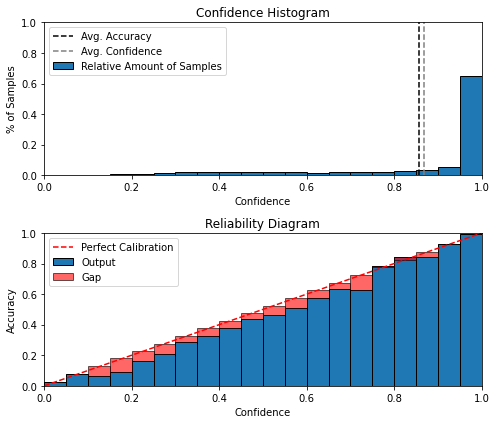

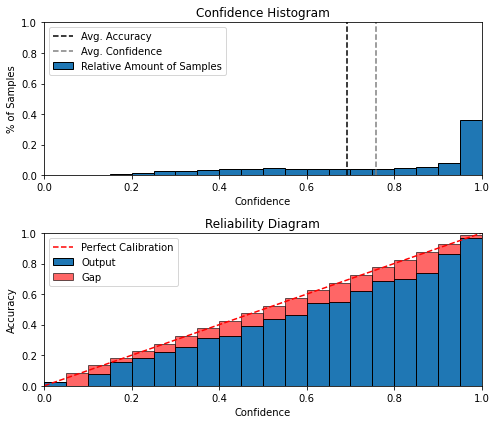

In [4]:
batch_size = 64
device = 'cuda'

train_loader, test_loader, _, _ = create_loader(batch_size, "./data/", "CIFAR100")

TestModel("resnet20", test_loader, lrp_gamma=15)